In [1]:
# default preprocessing_pipeline

# Preprocessing pipeline

In this notebook we try to find the steps in a preprocessing pipeline that lead to a relatively homogeneous dimensionality reduction of the control samples. The idea is that we expect no process of interest in the control samples, so a good preprocessing strategy should reflect that and not introduce any unwanted artifacts. If this same strategy is applied on case (infected) samples, we can assume that effects showing up in down stream analyses are due to biological or technical artifacts and not due to the preprocessing.

See [slides](https://slides.com/mlippie/normalization-strategy)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# %load common_.py
from common import *

In [4]:
# export
from ehv import correlation
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import FastICA, PCA, KernelPCA
from umap import UMAP
from multiprocessing import Pool, cpu_count

In [5]:
df = e_load.load_raw_ideas_dir(
    Path("/data/weizmann/EhV/high_time_res"), 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/representations/ideas_features/"), 
    "ALL", 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/cell_populations/manual_gating/"),
    None, "*.cif")
df = e_load.remove_unwanted_features(df)
df = e_load.tag_columns(df)
df = e_load.clean_column_names(df)

df = df[df["meta_label_coi"]]

reg = r"^meta_label_(.+)$"
label_vec = numpy.full((df.shape[0]), fill_value="unknown", dtype=object)
for col in df.filter(regex="(?i)meta_label_.*psba.*"):
    label_vec[df[col].values] = re.match(reg, col).groups(1)
    
df["meta_label"] = label_vec

df = df.reset_index(drop=True)

## Setting up preprocessing pipelines

Steps:
1. Correlation
1. Scaling
1. Dimensionality reduction

In [9]:
# export
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.base import TransformerMixin, BaseEstimator, clone

In [10]:
# export
class GroupedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, base_transformer, group_key, n_jobs=-1):
        self.base_transformer = base_transformer
        self.group_key = group_key
        self.n_jobs = n_jobs if n_jobs >= 1 else cpu_count()
        
    def fit(self, df):
        self.transformers = {}
        with Pool(processes=self.n_jobs) as pool:
            for idx, gdf in df.groupby(self.group_key):
                self.transformers[idx] = pool.apply_async(clone(self.base_transformer).fit, args=(gdf.drop(columns=self.group_key),))
            for k,v in self.transformers.items():
                self.transformers[k] = v.get()
        return self
            
    def transform(self, df):
        columns = df.drop(columns=self.group_key).columns
        dfs = []
        with Pool(processes=self.n_jobs) as pool:
            promises = []
            for idx, gdf in df.groupby(self.group_key):
                promises.append(pool.apply_async(self.transformers[idx].transform, args=(gdf[columns],)))
            for (promise, (idx, gdf)) in zip(promises, df.groupby(self.group_key)):
                gdf[columns] = promise.get()
                dfs.append(gdf)
        return pandas.concat(dfs)
    
class ColumnTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformer, col_selector, append=False):
        self.transformer = transformer
        self.col_selector = col_selector
        self.append = append
        
    def fit(self, df, y=None):
        self.transformer.fit(df[self.col_selector(df)])
        return self
    
    def transform(self, df, y=None):
        tmp = self.transformer.transform(df[self.col_selector(df)])
        if self.append:
            if hasattr(tmp, "iloc"):
                return pandas.concat([df, tmp], axis=1)
            else:
                for i in range(tmp.shape[1]):
                    df["feat_%s_%s" % (self.transformer.__class__.__name__.lower(), i)] = tmp[:, i]
                return df
        else:
            return pandas.concat([df.drop(columns=self.col_selector(df)), tmp], axis=1)
        
    
class SelectColumnsTransfomer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=[]):
        self.columns = columns

    def transform(self, X, y=None, **transform_params):
        trans = X[self.columns].copy() 
        return trans

    def fit(self, X, y=None, **fit_params):
        return self

In [11]:
feat_selector = make_column_selector(pattern="feat")
meta_selector = make_column_selector(pattern="^(feat|meta_timepoint).*")

In [12]:
pipe = Pipeline([
    ("correlation", ColumnTransformer(correlation.Correlation(0.92), meta_selector)),
    ("grouped_robust_scaler", ColumnTransformer(GroupedTransformer(RobustScaler(quantile_range=(0.05, 0.95)), "meta_timepoint"), meta_selector)),
    ("pca", ColumnTransformer(PCA(n_components=0.95, random_state=42), feat_selector, append=True)),
    ("umap", ColumnTransformer(UMAP(n_components=2, random_state=42), make_column_selector(pattern="feat_pca"), append=True))
])

In [14]:
%%time
res = pipe.fit_transform(df[df["meta_group"] == "Ctrl"])

CPU times: user 49min 19s, sys: 15min 22s, total: 1h 4min 42s
Wall time: 7min 46s


<AxesSubplot:xlabel='feat_umap_0', ylabel='feat_umap_1'>

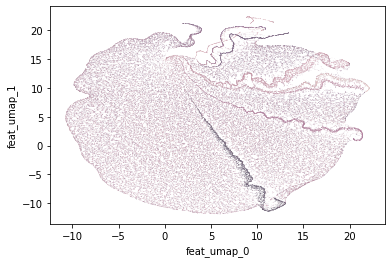

In [15]:
seaborn.scatterplot(data=res, x="feat_umap_0", y="feat_umap_1", hue="meta_timepoint", s=0.1, alpha=0.5, edgecolors='none', legend=False)

<AxesSubplot:xlabel='feat_umap_0', ylabel='feat_umap_1'>

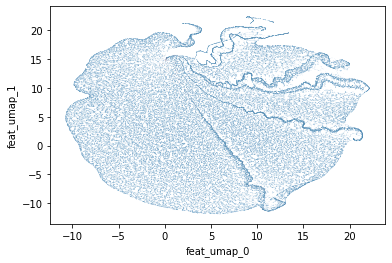

In [16]:
seaborn.scatterplot(data=res, x="feat_umap_0", y="feat_umap_1", hue="meta_label", hue_order=["mcp_neg_psba_pos", "mcp_pos_psba_pos", "mcp_pos_psba_neg", "mcp_neg_psba_neg", "unknown"], legend=False, s=0.1, alpha=0.5, edgecolors='none')

In [18]:
%%time
pipe = Pipeline([
    ("correlation", ColumnTransformer(correlation.Correlation(0.92), meta_selector)),
    ("grouped_minmax_scaler", ColumnTransformer(GroupedTransformer(MinMaxScaler(), "meta_timepoint"), meta_selector)),
    ("grouped_standard_scaler", ColumnTransformer(GroupedTransformer(StandardScaler(), "meta_timepoint"), meta_selector)),
    ("pca", ColumnTransformer(PCA(n_components=0.95, random_state=42), feat_selector, append=True)),
    ("umap", ColumnTransformer(UMAP(n_components=2, random_state=42), make_column_selector(pattern="feat_pca"), append=True))
])
res2 = pipe.fit_transform(df[df["meta_group"] == "Ctrl"])

CPU times: user 11min 48s, sys: 3min 19s, total: 15min 7s
Wall time: 3min 47s


<AxesSubplot:xlabel='feat_umap_0', ylabel='feat_umap_1'>

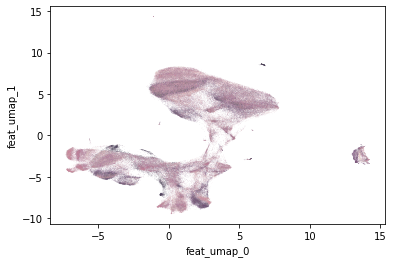

In [19]:
seaborn.scatterplot(data=res2, x="feat_umap_0", y="feat_umap_1", hue="meta_timepoint", s=0.1, alpha=0.5, edgecolors='none', legend=False)

In [54]:
def do_median_centering(df):
    df[df.filter(regex="feat").columns] -= df.median()
    return df

df = df.groupby(["meta_timepoint", "meta_replicate"]).apply(do_median_centering)

In [81]:
def do_mean_centering(df):
    df[df.filter(regex="feat").columns] -= df.mean()
    return df

df = df.groupby(["meta_timepoint"]).apply(do_mean_centering)